| Title                                                   | Date       | Author          |
|---------------------------------------------------------|------------|-----------------|
| Building RAGs using Haystack - Jupyter Notebook Version | 2025-05-20 | Antonio Del Rio |
---

# 1. Introduction and Terminology
This tutorial provides a comprehensive, step-by-step guide for building a RAG pipeline using the open-source Haystack
framework. In this walkthrough, you will learn how to install and configure Haystack, prepare your knowledge base using various data formats (such as text files, PDFs, and website content), embed documents, and construct a fully functional RAG pipeline that answers questions grounded in external data.

Note - This tutorial was inspired by and builds upon the concepts and implementations presented in the following resources:
- [Haystack Tutorial: Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline)
- [DeepLearning.AI Short Course: Building AI Applications with Haystack](https://www.deeplearning.ai/short-courses/building-ai-applications-with-haystack/)

---

**Haystack** is an open-source framework for building search and question-answering systems powered by Natural
Language Processing (NLP). It supports various components such as document retrieval, question answering, and
generative models, making it suitable for implementing complex pipelines like Retrieval-Augmented Generation (RAG).
The full documentation for Haystack can be found [here](https://docs.haystack.deepset.ai/docs/intro).

**Retrieval-Augmented Generation (RAG)** is a pipeline technique that retrieves relevant information from a
knowledge base to produce more accurate and contextually relevant answers to a provided query. Instead of relying on
the generative model's training data to generate a response, the RAG pipeline retrieves relevant documents from a
defined set of documents (the knowledge base) and passes them onto the generative model to generate a response. This
approach allows the
model to access external up-to-date information to more accurately respond to queries.

Example of queries to generative models with and without RAG pipeline:
- *Without* RAG pipeline: Answer the question (based on what you have been trained on)
- *With* RAG pipeline: Answer the question AND base your answer on the provided document(s)

Key terminology:

| Term                 | What It Means                                                                                               |
|----------------------|-------------------------------------------------------------------------------------------------------------|
| **Document**         | A unit of text (e.g. paragraph, webpage, etc.)                                                              |
| **Chunking**         | Splitting longer documents into smaller, more manageable parts (chunks) before passing through the embedder |
| **Embedder**         | Turns text into numerical vectors (embeddings)                                                              |
| **Document Store**   | A storage component that holds chunked embedded documents                                                   |
| **Retriever**        | Finds relevant documents based on a query (using vector similarity)                                         |
| **Reader/Generator** | Extracts/Generates answers from retrieved documents                                                         |


# 2. Haystack Installation and Environment Setup

## Haystack Installation

Haystack and its required packages can be installed from *haystack-ai* using pip, uv, or any other preferred package
manager:

```console
pip install haystack-ai
```

To use Haystack components for Google's Gemini model, *google-ai-haystack* and its required packages need to
 be installed in addition:
```console
pip install google-ai-haystack
```

## API Key Setup
When building a RAG pipeline, certain components may use AI models that require access to an API key.
In this documentation, the following components require an API key:

- OpenAIDocumentEmbedder → requires OPENAI_API_KEY
- OpenAITextEmbedder → requires OPENAI_API_KEY
- OpenAIChatGenerator → requires OPENAI_API_KEY
- GoogleAIGeminiChatGenerator → requires GOOGLE_API_KEY

To store API keys for use in the RAG pipeline, a .env file can be created in the project space and the API
keys can be listed in the file:
```text
OPENAI_API_KEY = ...OpenAI API key goes here...
GOOGLE_API_KEY = ...Google Gemini API key goes here...
```

To access the .env file containing the API keys, the library *dotenv* is needed:
```console
pip install dotenv
```
When working in a jupyter notebook Python environment (such as this one), the following code can be used to load the .env file:

In [1]:
%load_ext dotenv
%dotenv

If the API keys have previously been loaded, they can be reloaded by calling the following method:

In [2]:
%reload_ext dotenv

# 3. Haystack Components for Building a RAG Pipeline

## Document Store
To store the documents from the knowledge base, we can initialize a Haystack document store object. This object is
essentially a database for the knowledge base which the RAG's retriever can then access when a query is provided.
The simplest document store that can be used is *InMemoryDocumentStore()*:

In [3]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

 The document embedding step can be streamlined by creating a Haystack Pipeline object, adding and connecting the components to it, and feeding the
documents through the object.

Firstly, the necessary components need to be imported. In the below example, since the data source (knowledge base)
is in the form of a .txt file, the component *TextFileToDocument* can be used to automatically convert the text file
into a valid Haystack Document object. Haystack offers a wide variety of converter components to convert .csv, .html,
.doc and more data sources into valid Haystack Document objects, all of which can be found
[here](https://docs.haystack.deepset.ai/docs/converters).

The data source *edison.txt* used in this example is the book [*Edison: His Life and Inventions* by Frank Lewis Dyer and Thomas Commerford Martin](https://www.gutenberg.org/ebooks/820). This is a narrative of the famous inventor and businessman Thomas Edison that has been uploaded to the Project Gutenberg Library.

In [4]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.components.writers import DocumentWriter

# Pipeline handles documents in text form and automatically writes (stores embeddings of) them into document_store
data_source = "haystack_tutorial_data/edison.txt"

converter = TextFileToDocument()
splitter = DocumentSplitter()
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store=document_store)

Next a Haystack Pipeline can be initialized, and the required components can be added to this object using the *.
add_component()" method:

In [5]:
from haystack import Pipeline
indexing_pipeline = Pipeline()

indexing_pipeline.add_component(name="converter", instance=converter)
indexing_pipeline.add_component(name="splitter", instance=splitter)
indexing_pipeline.add_component(name="embedder", instance=embedder)
indexing_pipeline.add_component(name="writer", instance=writer)

The added components must then be connected correctly to build the pipeline. The steps for properly processing the
documents for the knowledge base are:

1. Convert data source into a proper Haystack document object using the converter component
2. Chunk the documents into smaller documents using the splitter component
3. Embed the chunked documents using the embedder component
4. Write the embeddings to the document store using the writer component

The components can be connected together using the *.connect()* method:

In [6]:
indexing_pipeline.connect(sender="converter", receiver="splitter")
indexing_pipeline.connect(sender="splitter", receiver="embedder")
indexing_pipeline.connect(sender="embedder", receiver="writer")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

Now that the pipeline for embedding the documents has been properly created, the pipeline can be run be calling the
*.run()* method and defining the data source to be passed into the converter component (the first component of the
pipeline):

In [7]:
indexing_pipeline.run({"converter": {"sources": [data_source]}})

Calculating embeddings: 41it [00:44,  1.09s/it]


{'embedder': {'meta': {'model': 'text-embedding-ada-002-v2',
   'usage': {'prompt_tokens': 365827, 'total_tokens': 365827}}},
 'writer': {'documents_written': 1307}}

To visualize the created Haystack Pipeline and how the pipeline's components are connected to each other, the *.show()*
method can be used:

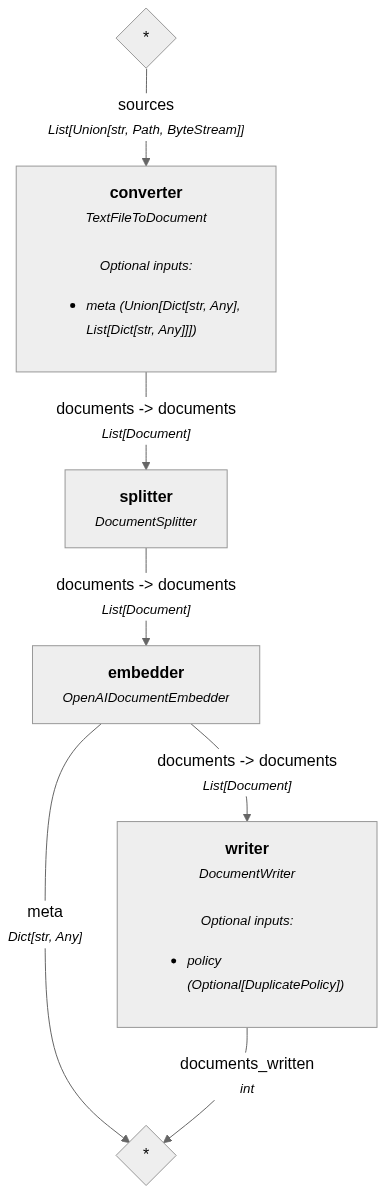

In [8]:
indexing_pipeline.show()

## Prompt Layout

In a RAG pipeline, the idea is for the AI model to answer the question and base its answer on the provided
document(s). The prompt that goes to the AI model should therefore be:

- Given the following information, answer the question.
- Context: Loop through all documents in knowledge base
- Question: User's query / question
- Answer: To be given by AI model

Using the Haystack dataclass *ChatMessage* and Jinja2 looping syntax, the following RAG prompt template can be
defined, which loops through the documents in the knowledge base and takes in the user's
query:

In [9]:
from haystack.dataclasses import ChatMessage

prompt = [ChatMessage.from_user("""
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
""")
          ]

## Query Embedding, Prompt Building, and Putting RAG Together

With the prompt template defined above, a new Haystack Pipeline can be built to take the user's query and embedded
chunked documents, pass them through an AI model, and return an answer to the user's query.

Firstly, the following necessary components need to be imported and added to the RAG Haystack Pipeline object:
- *query_embedder* → Embeds text (which will be the user's query)
- *retriever* → Retrieves chunked document embeddings stored in the defined document store
- *prompt_builder* → Builds the prompt based on the prompt template to be given to the AI model
- *chat_generator* → Takes in the user's full prompt, passes it through the Gemini AI model, and
  returns an answer to the user's query
  - *GoogleAIGeminiChatGenerator* → Uses Google's Gemini chat model for generating an answer to the prompt
  - *OpenAIChatGenerator* → Uses OpenAI's chat model for generating an answer to the prompt


In [10]:
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator
# from haystack.components.generators.chat import OpenAIChatGenerator --> OpenAI Chat Generator

query_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = ChatPromptBuilder(template=prompt)
chat_generator = GoogleAIGeminiChatGenerator()
# chat_generator = OpenAIChatGenerator(model="gpt-4o-mini") --> use for OpenAI Chat Generator

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", chat_generator)

/Volumes/Antonio 1TB/DF/Github_Repo/df-engineering/content/articles/haystack-tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


To complete the RAG pipeline, the above-added components need to be connected correctly. The
steps for properly
processing the user's query in a RAG pipeline are:

1. Embed the user's query using the query embedder component
2. Retrieve the chunked document embeddings stored in the defined document store using the retriever component
3. Build a prompt using the defined prompt template and the prompt builder component
4. Pass the full prompt to the AI model to generate an answer to the user's query using the chat generator component


In [11]:
rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder.prompt", "llm.messages")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - llm: GoogleAIGeminiChatGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

With the RAG pipeline fully built, it can be run by calling the *.run()* method. To run the RAG pipeline, the user must:
1. Define their query; and
2. Specify the integer value for the *top_k* parameter, which controls the number of top document chunks are
   retrieved based on the similarity to the user's query

After running the RAG pipeline, the response returned by the RAG pipeline can then be called and displayed:


In [13]:
question = "When did Edison become famous?"

response = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 10},
        "prompt_builder": {"question": question},
    }
)

rag_response = response["llm"]["replies"][0].text
print(rag_response)

The provided text states that the phonograph's launch in 1878 made Edison a world sensation, leading to widespread media coverage and the creation of an "Edison myth."  However, his inventive career began much earlier, with his first patent in 1869.  His inventive activity peaked around 1882, with a significant number of patents applied for and granted that year.  Therefore, there's no single date for when he became famous, but rather a period of increasing recognition starting in 1878 and accelerating through the 1880s.



# 4. Building Custom Haystack Components


The above RAG pipeline example has been built entirely with existing Haystack components. Haystack also has support for building custom components. Each Haystack component must fulfill the following requirements:
1. It must be a class with the ```@component``` decorator
2. It must include a ```run()``` method with a ```@component.output_types```decorator
3. It must return a dictionary

An example of a simple component is the following:

In [14]:
from haystack import component

@component # class with @component decorator
class favorite_animal:

    @component.output_types(output=str) # run() method with @component.output_types decorator
    def run(self, animal_name: str):
        return {"output": f"My favorite animal is the {animal_name}!"} # dictionary returned

With the custom component ```favorite_animal``` built, it can be called and run:

In [15]:
my_favorite_animal = favorite_animal()
my_favorite_animal.run(animal_name="dog")

{'output': 'My favorite animal is the dog!'}

As with the preset Haystack components, custom Haystack components can be added to Haystack pipelines. In the below example, the pipeline will:

1. Construct the sentence "My favorite animal is the ```{{ favorite_animal }}```!" given the inputted ```favorite_animal``` (custom component ```favorite_animal()```)
2. Prompts the Google Gemini AI agent to write a short paragraph about the given favorite animal (preset component ```ChatPromptBuilder()```)
3. Generate the short paragraph about the given favorite animal given the existing knowledge of the AI agent (preset component ```GoogleAIGeminiChatGenerator()```)

First initialize the prompt to pass to the AI agent:

In [16]:
from haystack.dataclasses import ChatMessage

prompt = [ChatMessage.from_user("""
You are given the name of the favorite animal of the user. Write a short paragraph about the animal.
Start of paragraph: {{ favorite_animal }}
Paragraph:
""")]

Next, initialize the two preset components:

In [17]:
# custom component
my_favorite_animal = favorite_animal()

# preset components
from haystack.components.builders import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator

prompt_builder = ChatPromptBuilder(template=prompt)
chat_generator = GoogleAIGeminiChatGenerator()

ChatPromptBuilder has 1 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


Next, initialize the Haystack pipeline, add the three components, and connect them correctly:

In [18]:
from haystack import Pipeline

favorite_animal_pipeline = Pipeline()
favorite_animal_pipeline.add_component("my_favorite_animal", my_favorite_animal)
favorite_animal_pipeline.add_component("prompt_builder", prompt_builder)
favorite_animal_pipeline.add_component("llm", chat_generator)

favorite_animal_pipeline.connect("my_favorite_animal.output", "prompt_builder.favorite_animal")
favorite_animal_pipeline.connect("prompt_builder.prompt", "llm.messages")

🚅 Components
  - my_favorite_animal: favorite_animal
  - prompt_builder: ChatPromptBuilder
  - llm: GoogleAIGeminiChatGenerator
🛤️ Connections
  - my_favorite_animal.output -> prompt_builder.favorite_animal (str)
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

Finally, generate the desired answer for your favorite animal (in this example, the author's favorite animal is the dog):

In [19]:
# run the pipeline to generate a complete answer
answer = favorite_animal_pipeline.run({"my_favorite_animal": {"animal_name": "dog"}})

# display the text of the AI agent's reply
print(answer["llm"]["replies"][0].text)

My favorite animal is the dog!  Dogs are incredibly diverse creatures, ranging from tiny Chihuahuas to giant Great Danes, each with their own unique personality and appearance.  Their unwavering loyalty and playful nature have made them beloved companions for thousands of years.  Beyond their companionship, dogs possess a remarkable intelligence and capacity for training, making them valuable working animals in various fields, from assisting law enforcement to providing comfort to those in need.  Their ability to understand and respond to human emotions adds to their special bond with us, cementing their place as one of the most cherished animals in the world.



# 5. Converting PDFs into Documents


The above examples have considered information for the RAG's knowledge base as pure text stored in a .txt file. Haystack has various converter components that can convert data in various forms into the embedding form for the RAG to be able to use. This section covers the simplest method to convert documents in PDF form into Haystack documents.

To convert a PDF into content that can be stored in the knowledge base of the RAG, the Haystack component *PyPDFToDocument* is used. The *pypdf* package needs to be installed to use the Haystack component, which needs to be installed:

```console
pip install pypdf
```
To demonstrate the functionality of the converter, the below code can be run. The file path to a document (in this example, "How to write a research proposal (Research proposal guide" from the UZH Department of Finance is used). The converter is first initialized and the document's file path is passed into the run method of the converter. The *sources* parameter of the run method can take in a list of file paths to convert multiple PDFs into a list of document text.


In [20]:
from haystack.components.converters import PyPDFToDocument

file_path = 'haystack_tutorial_data/document_uzh.pdf'
converter = PyPDFToDocument()
docs = converter.run(sources=[file_path])

The contents of the above *docs* object can be inspected by printing out the contents of each document:

In [21]:
for i, doc in enumerate(docs['documents']):
    print(f"\n--- Document {i+1} ---\n")
    print(doc.content)


--- Document 1 ---

 
Department of Finance 
 
 
How to write a research proposal (Research proposal guide) 
 
The research proposal of a thesis is a fundamental summary of the research project. The challenge of the topic 
proposal is to choose a satisfactory topic. Do not be disheartened, if you do not find a suitable topic right away. 
 
Component of the research proposal 
 
Title: The title should impart the core of the research project explicit and concise. 
 
Hypothesis or research enqu iry (objective): Describe, which paradox you are trying to solve and 
what the motivation behind it is. Show why this topic is worth working on. Your proposed problem 
should be precisely focused, but not trivial. Articulate specific hypotheses that you would like to test 
in your thesis. 
 
Data: Specify what data you will use and where you will source it from. The data set you will use must 
be clearly described and you must explain its suitability. Before submitting the proposal, check 
whether

The process of converting PDFs into document embeddings for a RAG pipeline to use can be streamlined using a Haystack Pipeline. The object *pdf_embedder_pipeline* has the following components:
- Converter → Converts PDF into a text document
- Cleaner → Cleans the text document by removing things like empty lines, unsupported characters, extra whitespaces, etc.
- Splitter → Chunks the document into a list of smaller documents
- Embedder → Turns the chunked documents into numerical vectors
- Writer → Stores chunked document embeddings in the document store object

After adding and connecting the pipeline's components, the pipeline can be run for the file paths of the PDFs.



In [22]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()
file_paths = ["haystack_tutorial_data/document_uzh.pdf"]

pdf_embedder_pipeline = Pipeline()

converter = PyPDFToDocument()
cleaner = DocumentCleaner()
splitter = DocumentSplitter()
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store=document_store)

pdf_embedder_pipeline.add_component("converter", converter)
pdf_embedder_pipeline.add_component("cleaner", cleaner)
pdf_embedder_pipeline.add_component("splitter", splitter)
pdf_embedder_pipeline.add_component("embedder", embedder)
pdf_embedder_pipeline.add_component("writer", writer)

pdf_embedder_pipeline.connect("converter", "cleaner")
pdf_embedder_pipeline.connect("cleaner", "splitter")
pdf_embedder_pipeline.connect("splitter", "embedder")
pdf_embedder_pipeline.connect("embedder", "writer")

pdf_embedder_pipeline.run({"converter": {"sources": file_paths}})

Calculating embeddings: 1it [00:00,  1.74it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002-v2',
   'usage': {'prompt_tokens': 603, 'total_tokens': 603}}},
 'writer': {'documents_written': 3}}

As was done for previous RAG pipelines, the following prompt template can be defined:

In [23]:
from haystack.dataclasses import ChatMessage

prompt = [ChatMessage.from_user("""
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
""")
          ]

The RAG pipeline can then be built in the same was as was shown previously:

In [24]:
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator

query_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = ChatPromptBuilder(template=prompt)
chat_generator = GoogleAIGeminiChatGenerator()

pdf_document_rag = Pipeline()

pdf_document_rag.add_component("query_embedder", query_embedder)
pdf_document_rag.add_component("retriever", retriever)
pdf_document_rag.add_component("prompt_builder", prompt_builder)
pdf_document_rag.add_component("llm", chat_generator)

pdf_document_rag.connect("query_embedder.embedding", "retriever.query_embedding")
pdf_document_rag.connect("retriever.documents", "prompt_builder.documents")
pdf_document_rag.connect("prompt_builder.prompt", "llm.messages")

ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - llm: GoogleAIGeminiChatGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

With the PDF to embeddings pipeline and RAG pipeline ready, questions relating to the contents of the PDF document can now be asked in the same way as was shown previously:

In [25]:
question = "What should the hypothesis be in the research proposal?"

response = pdf_document_rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 5},
        "prompt_builder": {"question": question},
    }
)

rag_response = response["llm"]["replies"][0].text
print(rag_response)

The hypothesis, or research inquiry (objective), should describe the paradox the researcher is trying to solve and the motivation behind it.  It should explain why the topic is worth working on, be precisely focused but not trivial, and articulate specific hypotheses to be tested in the thesis.  The hypothesis must conform to existing literature or arise from it.  If not formulated as a hypothesis or distinct statement, the problem must be precisely expressed and specified, along with a justification for its worth.



It is important to note that the *pypdf* package used by the *PyPDFToDocument* Haystack component is limited in how well it can convert PDFs into text. Data such as tables, images, and hyperlinks cannot be properly converted into text using this component alone. There are solutions such as [Docling](https://github.com/docling-project/docling) that can be implemented to address these issues.

# 6. Converting Website Content into Documents

This section covers the simplest method to convert data stored on websites into Haystack documents.

To convert the content of a website into a form that a RAG can use, the Haystack components *LinkContentFetcher* and *HTMLToDocument* are used. The former fetches data from a website link as an HTML file, while the latter converts the fetched HTML file into a document object.

To demonstrate the functionality of the converter, the below code can be run. The website links (in this example, the "Master of Arts in Banking and Finance" info-page from the UZH Department of Finance is used) can be specified in a list object. The fetcher and converter are first initialized, the website links are then passed into the run method of the fetcher, and then the HTML objects are passed into the run method of the converter. Both the *urls* and *sources* parameters of the fetcher and converter respectively are lists.


In [27]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

urls = ["https://www.df.uzh.ch/en/studies/bachelor-master/master/ma-banking-finance.html"]

fetcher = LinkContentFetcher()
converter = HTMLToDocument()

website_fetcher = fetcher.run(urls=urls)

website_docs = converter.run(sources=website_fetcher['streams'])

The contents of the above *docs* object can be inspected by printing out the contents of each document:


In [28]:
import sys
print(sys.executable)

/Volumes/Antonio 1TB/DF/Github_Repo/df-engineering/content/articles/haystack-tutorial/.venv/bin/python


In [29]:
for i, doc in enumerate(website_docs['documents']):
    print(f"\n--- Document {i+1} ---\n")
    print(doc.content)


--- Document 1 ---

Master of Arts in Banking and Finance
The Master's program in Banking and Finance has an academic focus and is designed to provide students with a strong foundation in both research and practice. The program also includes practice-oriented lectures, guest lectures from business professionals, and seminars supervised by industry partners, all of which allow students to gain early exposure to the professional world.
It is worth noting that the majority of the program's modules are offered in English, which means that a good command of the English language is a prerequisite for the Master's program in Banking and Finance. This language requirement ensures that graduates are well-equipped to work in a globalized business environment where English is often the primary language used in professional settings.
Subject Areas
The Master of Arts in Banking and Finance program at the Department of Finance offers five majors: Banking, Corporate Finance, Financial Economics, Qua

The process of converting website content into document embeddings for a RAG pipeline to use can be streamlined using a Haystack Pipeline. The object *website_embedder_pipeline* is almost exactly the same as the *pdf_embedder_pipeline* from the previous section, except there is an additional *LinkContentFetcher*  component and the *PyPDFToDocument* component is replaced with the *HTMLToDocument* component.

After adding and connecting the pipeline's components, the pipeline can be run for website links.

In [30]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()

websites = ["https://www.df.uzh.ch/en/studies/bachelor-master/master/ma-banking-finance.html"]

website_embedder_pipeline = Pipeline()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
cleaner = DocumentCleaner()
splitter = DocumentSplitter()
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store=document_store)

website_embedder_pipeline.add_component("fetcher", fetcher)
website_embedder_pipeline.add_component("converter", converter)
website_embedder_pipeline.add_component("cleaner", cleaner)
website_embedder_pipeline.add_component("splitter", splitter)
website_embedder_pipeline.add_component("embedder", embedder)
website_embedder_pipeline.add_component("writer", writer)

website_embedder_pipeline.connect("fetcher", "converter")
website_embedder_pipeline.connect("converter", "cleaner")
website_embedder_pipeline.connect("cleaner", "splitter")
website_embedder_pipeline.connect("splitter", "embedder")
website_embedder_pipeline.connect("embedder", "writer")

website_embedder_pipeline.run({"fetcher": {"urls": websites}})

Calculating embeddings: 1it [00:00,  2.57it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002-v2',
   'usage': {'prompt_tokens': 502, 'total_tokens': 502}}},
 'writer': {'documents_written': 3}}

The same prompt template and RAG pipeline from the previous section can be reused:

In [31]:
from haystack.dataclasses import ChatMessage

prompt = [ChatMessage.from_user("""
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
""")
          ]

In [32]:
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator

query_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = ChatPromptBuilder(template=prompt)
chat_generator = GoogleAIGeminiChatGenerator()

website_rag = Pipeline()

website_rag.add_component("query_embedder", query_embedder)
website_rag.add_component("retriever", retriever)
website_rag.add_component("prompt_builder", prompt_builder)
website_rag.add_component("llm", chat_generator)

website_rag.connect("query_embedder.embedding", "retriever.query_embedding")
website_rag.connect("retriever.documents", "prompt_builder.documents")
website_rag.connect("prompt_builder.prompt", "llm.messages")

ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - llm: GoogleAIGeminiChatGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

With the website to embeddings pipeline and RAG pipeline ready, questions relating to the contents of the website can now be asked in the same way as was shown previously:


In [33]:
question = "What majors chan I choose in the UZH Master of Banking and Finance?"

response = website_rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 5},
        "prompt_builder": {"question": question},
    }
)

rag_response = response["llm"]["replies"][0].text
print(rag_response)

You can choose from five majors in the UZH Master of Arts in Banking and Finance program: Banking, Corporate Finance, Financial Economics, Quantitative Finance, and Sustainable Finance.



As was the case for the PDF converter in the previous section, the fetcher and converter components used for retrieving website data cannot convert more complicated forms of data, such as tables, photos, and hyperlinks, into text format. There are solutions such as [Firecrawl](https://www.firecrawl.dev) that can be implemented to address these issues.